In [1]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import os

import pandas as pd
import numpy as np
import shap
import joblib
from typing import List, NamedTuple

In [2]:
input_cols = [
    "gen_other",
    "gen_solar",
    "gen_wind_on",
    "gen_waste",
    "gen_nuclear",
    "gen_biomass",
    "gen_gas",
    "gen_run_off_hydro",
    "gen_oil",
    "gen_pumped_hydro",
    "gen_other_renew",
    "gen_reservoir_hydro",
    "gen_hard_coal",
    "gen_wind_off",
    "gen_geothermal",
    "gen_lignite",
    "load",
    "gen_coal_gas",
    "total_gen",
    "synchronous_gen",
    "load_ramp",
    "total_gen_ramp",
    "other_ramp",
    "solar_ramp",
    "wind_on_ramp",
    "waste_ramp",
    "nuclear_ramp",
    "biomass_ramp",
    "gas_ramp",
    "run_off_hydro_ramp",
    "oil_ramp",
    "pumped_hydro_ramp",
    "other_renew_ramp",
    "reservoir_hydro_ramp",
    "hard_coal_ramp",
    "wind_off_ramp",
    "geothermal_ramp",
    "lignite_ramp",
    "coal_gas_ramp",
    "forecast_error_wind_on",
    "forecast_error_wind_off",
    "forecast_error_solar",
    "forecast_error_total_gen",
    "forecast_error_load",
    "forecast_error_load_ramp",
    "forecast_error_total_gen_ramp",
    "forecast_error_wind_off_ramp",
    "forecast_error_wind_on_ramp",
    "forecast_error_solar_ramp",
    "solar_day_ahead",
    "wind_on_day_ahead",
    "scheduled_gen_total",
    "prices_day_ahead",
    "load_day_ahead",
    "wind_off_day_ahead",
    "month",
    "weekday",
    "hour",
    "load_ramp_day_ahead",
    "total_gen_ramp_day_ahead",
    "wind_off_ramp_day_ahead",
    "wind_on_ramp_day_ahead",
    "solar_ramp_day_ahead",
    "price_ramp_day_ahead",
    "gen_fossil_peat",
    "fossil_peat_ramp",
    "residual",
    "geothermal_ramp"
]


input_col_names = [
    "Generation other",
    "Solar generation",
    "Onshore wind generation",
    "Waste generation",
    "Nuclear generation",
    "Biomass generation",
    "Gas generation",
    "Run-off-river hydro generation",
    "Oil generation",
    "Pumped hydro generation",
    "Other renewable generation",
    "Reservoir hydro generation",
    "Hard coal generation",
    "Wind offshore generation",
    "Geothermal generation",
    "Lignite generation",
    "Load",
    "Coal gas generation",
    "Total generation",
    "Synchronous generation",
    "Load ramp",
    "Total generation ramp",
    "Other ramp",
    "Solar ramp",
    "Onshore wind ramp",
    "Waste ramp",
    "Nuclear ramp",
    "Biomass ramp",
    "Gas ramp",
    "Run-off-river hydro ramp",
    "Oil ramp",
    "Pumped hydro ramp",
    "Other renewable ramp",
    "Reservoir hydro ramp",
    "Hard coal ramp",
    "Offshore wind ramp",
    "geothermal_ramp",
    "Lignite ramp",
    "Coal gas ramp",
    "Forecast error onshore wind",
    "Forecast error offshore wind",
    "Forecast error solar",
    "Forecast error total generation",
    "Forecast error load",
    "Forecast error load ramp",
    "Forecast error generation ramp",
    "Forecast error offshore wind ramp",
    "Forecast error onshore wind ramp",
    "Forecast error solar ramp",
    "Solar day-ahead",
    "Onshore wind day-ahead",
    "Scheduled generation",
    "Prices day-ahead",
    "Load day-ahead",
    "Offshore wind day-ahead",
    "Month",
    "Weekday",
    "Hour",
    "Load ramp day-ahead",
    "Generation ramp day-ahead",
    "Offshore wind ramp day-ahead",
    "Onshore wind ramp day-ahead",
    "Solar ramp day-ahead",
    "Price ramp day-ahead",
    "Fossil peat generation",
    "Fossil peat ramp",
    "Residual",
    "Geothermal ramp"
]

input_col_names = dict(zip(input_cols, input_col_names))
#input_col_names_units = dict(zip(input_cols, input_col_names_units))
#input_col_names_units_general = dict(zip(input_cols, input_col_names_units_general))

input_rescale_factors = pd.Series(index=input_cols, data=1 / 1000)
input_rescale_factors.loc[
    ["weekday", "hour", "month", "prices_day_ahead", "price_ramp_day_ahead"]
] = 1


In [4]:
class Config(NamedTuple):
    data_version: str = "2024-05-19"
    res_version: str = "2024-08-27"
    model_type: str = "_full"
    model_combination: str = "tabnet_proba"
    predictors_prob: List[str] = ["baseline", "predictions"]
    model_names_prob: List[str] = ["Baseline", "TabNetProba"]
    predictors_det: List[str] = ["daily_profile", "predictions"]
    model_names_det: List[str] = ["Daily profile", "TabNetProba"]
    scaler_str = "yeo_johnson"
    scaled = "_scaled"  # if using the scaled data, use "_scaled as the string" otherwise use the empty string
    explanations: str = ""


config = Config()

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_double_correlation_heatmap(save=False, threshold=0.7):
    """
    Plots a double heatmap for the CE and Nordic areas, showing only correlations
    with absolute value greater than or equal to the specified threshold.
    
    Parameters:
    - threshold: float, the threshold for filtering correlations (default: 0.7).
    """
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    data_version = "2024-05-19"
    
    areas = ["CE", "Nordic"]
    figure_path = "../../probabilistic-XAI-for-grid-frequency-stability/results/figures/correlation/"
    
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
        
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 16), sharex=True)

    for i, area in enumerate(areas):
        version_folder = f"../data/2020-2024/{area}/version_{data_version}/yeo_johnson/"
        X_train = pd.read_hdf(version_folder + "X_train_full_scaled.h5")
        X_train.rename(columns=input_col_names, inplace=True)

        # Calculate and filter correlation matrix
        correlation_matrix = X_train.corr(method='pearson')
        filtered_corr_matrix = correlation_matrix.copy()
        filtered_corr_matrix[np.abs(filtered_corr_matrix) < threshold] = 0

        non_zero_columns = filtered_corr_matrix.columns[
            (np.abs(filtered_corr_matrix).sum(axis=0) - np.abs(np.diag(filtered_corr_matrix))) > 0
        ]
        filtered_corr_matrix = filtered_corr_matrix.loc[non_zero_columns, non_zero_columns]

        sns.heatmap(
            filtered_corr_matrix, annot=False, cmap="coolwarm", ax=axes[i],
            linewidths=.5, vmin=-1, vmax=1, cbar_kws={'label': 'Pearson Correlation' if i == 1 else None}
        )
        
        axes[i].set_title(r'Correlation Heatmap of ' + area + r' Features ($|corr| \geq ' + str(threshold) + r'$)', fontsize=16)
        axes[i].tick_params(axis='x', rotation=45)
        for tick in axes[i].get_xticklabels():
            tick.set_horizontalalignment('right')
            tick.set_verticalalignment('center_baseline')
            
    plt.tight_layout()
    if save:
        plt.savefig(figure_path + "double_corr_heatmap.pdf", bbox_inches='tight')
    plt.show()

# Example usage
plot_double_correlation_heatmap(threshold=0.7, save=True)


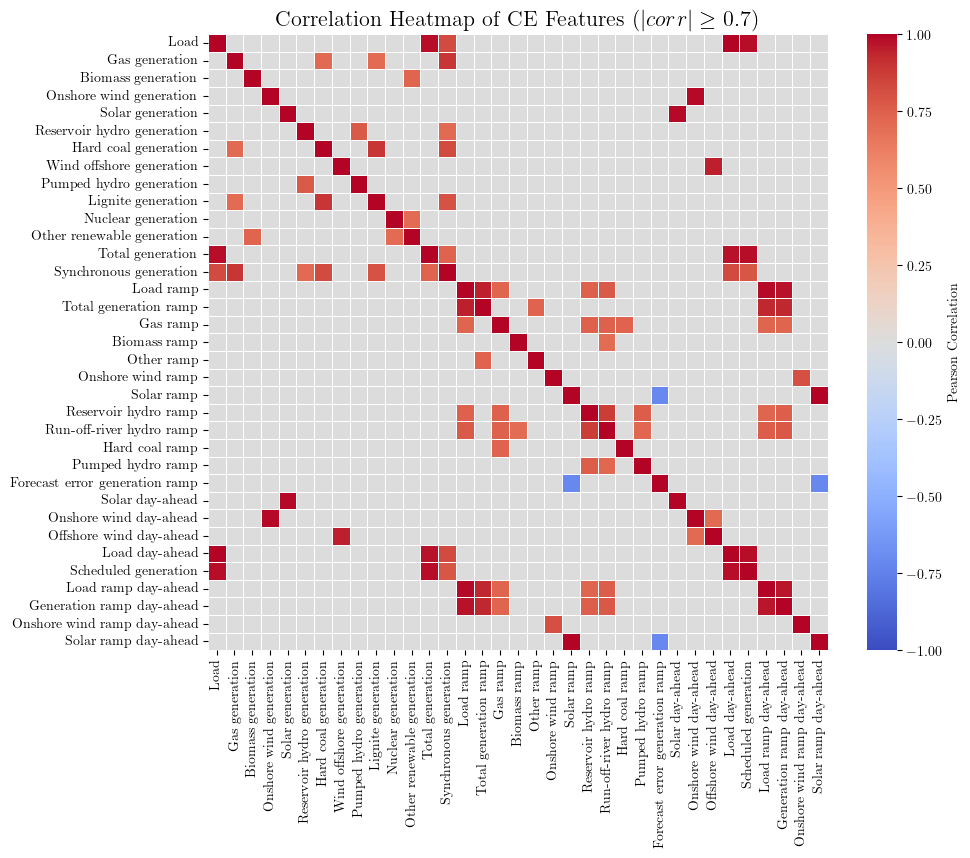

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_heatmap(area, save=False, threshold=0.7):
    """
    Plots a heatmap for the given correlation matrix, showing only correlations
    with absolute value greater than or equal to the specified threshold.
    
    Parameters:
    - correlation_matrix: pandas DataFrame, the correlation matrix.
    - threshold: float, the threshold for filtering correlations (default: 0.75).
    """
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    data_version = "2024-05-19"
    version_folder = f"../data/2020-2024/{area}/version_{data_version}/yeo_johnson/"
    X_train = pd.read_hdf(version_folder + "X_train_full_scaled.h5")
    X_train.rename(columns=input_col_names, inplace=True)
    figure_path = (
        f"../../probabilistic-XAI-for-grid-frequency-stability/results/figures/correlation/{area}/"
    )
    if not os.path.exists(figure_path):
            os.makedirs(figure_path)

    correlation_matrix = X_train.corr(method='pearson')
    filtered_corr_matrix = correlation_matrix.copy()
    filtered_corr_matrix[np.abs(filtered_corr_matrix) < threshold] = 0

    non_zero_columns = filtered_corr_matrix.columns[
        (np.abs(filtered_corr_matrix).sum(axis=0) - np.abs(np.diag(filtered_corr_matrix))) > 0
    ]
    filtered_corr_matrix = filtered_corr_matrix.loc[non_zero_columns, non_zero_columns]

    plt.figure(figsize=(10, 8))
    plt.xticks(rotation=90)

    sns.heatmap(
        filtered_corr_matrix, annot=False,  cmap="coolwarm",
        linewidths=.5, vmin=-1, vmax=1, cbar_kws={'label': 'Pearson Correlation'}
    )
    
    #plt.title(r'\textbf{SHAP Feature Importance for} \textit{' + target + r'} \textbf{in ' + area + '}', fontsize=14)
    plt.title(r'Correlation Heatmap of ' + area  + r' Features ($|corr| \geq ' + str(threshold) + r'$)', fontsize=16)
    if save:
        plt.savefig(figure_path + "corr_heatmap.pdf", bbox_inches='tight')
    plt.show()
    

# Example usage (assuming correlation_matrix exists)
plot_correlation_heatmap("CE", threshold=0.7, save=True)


In [8]:
import os
import pandas as pd
import numpy as np

X_test = pd.read_hdf(version_folder + "X_test_full_scaled.h5")
figure_path = (
    f"../../probabilistic-XAI-for-grid-frequency-stability/results/figures/correlation/{area}/"
)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

correlation_matrix = X_train.corr(method='pearson')

correlation_matrix_abs = np.abs(correlation_matrix)
dist_matrix_df = 1 - correlation_matrix_abs


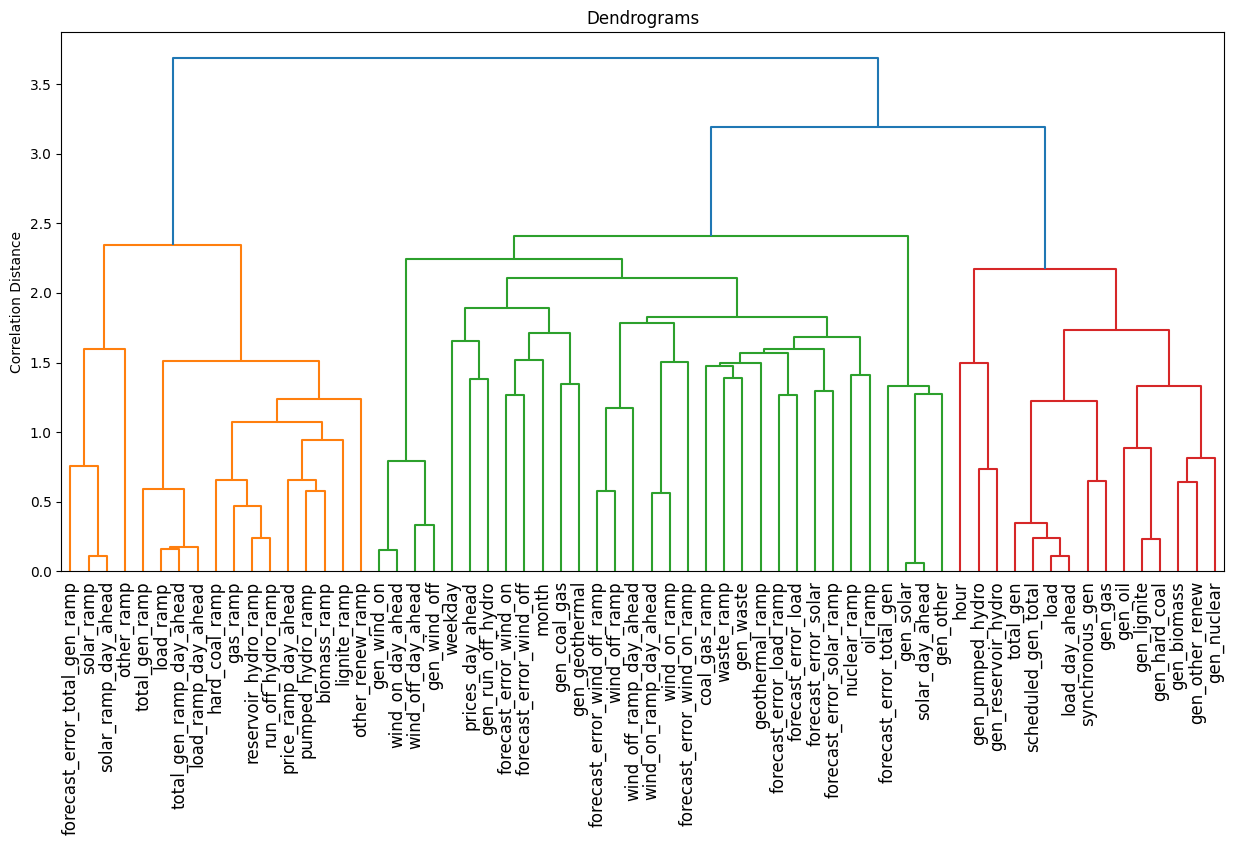

In [10]:
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

clustering = sch.linkage(dist_matrix_df, method="complete", optimal_ordering=True)
#Z = sch.linkage(X.T, method='ward')  # Transpose X to cluster features instead of samples

plt.figure(figsize=(15, 7))
plt.title("Dendrograms")
dend = sch.dendrogram(clustering, labels=X_train.columns)
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.ylabel('Correlation Distance')

#plt.savefig(figure_path + "pearson_corr.pdf", bbox_inches='tight')

plt.show()

In [48]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch


clustering = sch.linkage(dist_matrix, method="complete", optimal_ordering=True)

cluster_distances = clustering[:, 2]

nearest_feature_distances = {}

for i, (f1, f2, distance, _) in enumerate(clustering):
    if f1 < len(X_train.columns):  # f1 is a feature, not a cluster
        nearest_feature_distances[X_train.columns[int(f1)]] = distance
    if f2 < len(X_train.columns):  # f2 is a feature, not a cluster
        nearest_feature_distances[X_train.columns[int(f2)]] = distance

nearest_feature_df = pd.DataFrame.from_dict(nearest_feature_distances, orient='index', columns=['Distance'])
nearest_feature_df.rename(input_col_names,inplace=True)
three_smallest = nearest_feature_df.nsmallest(15, 'Distance')
three_largest = nearest_feature_df.nlargest(12, 'Distance')

print("Three features with the smallest distance to their nearest feature:\n", three_smallest)
print("\nThree features with the largest distance to their nearest feature:\n", three_largest)


Three features with the smallest distance to their nearest feature:
                            Distance
Load day-ahead             0.056531
Load                       0.056531
Onshore wind day-ahead     0.113082
Onshore wind generation    0.113082
Scheduled generation       0.113476
Total generation           0.133833
Generation other           0.149411
Fossil peat generation     0.149411
Hard coal generation       0.182807
Generation ramp day-ahead  0.245062
Total generation ramp      0.245062
Run-off-river hydro ramp   0.252385
Load ramp                  0.252385
Reservoir hydro ramp       0.284923
Hard coal ramp             0.289396

Three features with the largest distance to their nearest feature:
                                   Distance
Forecast error offshore wind      1.612805
Run-off-river hydro generation    1.578256
Offshore wind ramp day-ahead      1.514459
Oil ramp                          1.478444
Other renewable ramp              1.478444
Forecast error generation ra

/scratch/ipykernel_122212/650073551.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = sch.linkage(dist_matrix, method="complete", optimal_ordering=True)


In [49]:
list(three_largest.index)

['Forecast error offshore wind',
 'Run-off-river hydro generation',
 'Offshore wind ramp day-ahead',
 'Oil ramp',
 'Other renewable ramp',
 'Forecast error generation ramp',
 'Hour',
 'Nuclear ramp',
 'Prices day-ahead',
 'Weekday',
 'Other ramp',
 'Forecast error onshore wind ramp']

/scratch/ipykernel_187878/3388737462.py:30: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = sch.linkage(dist_matrix_df, method="complete", optimal_ordering=True)


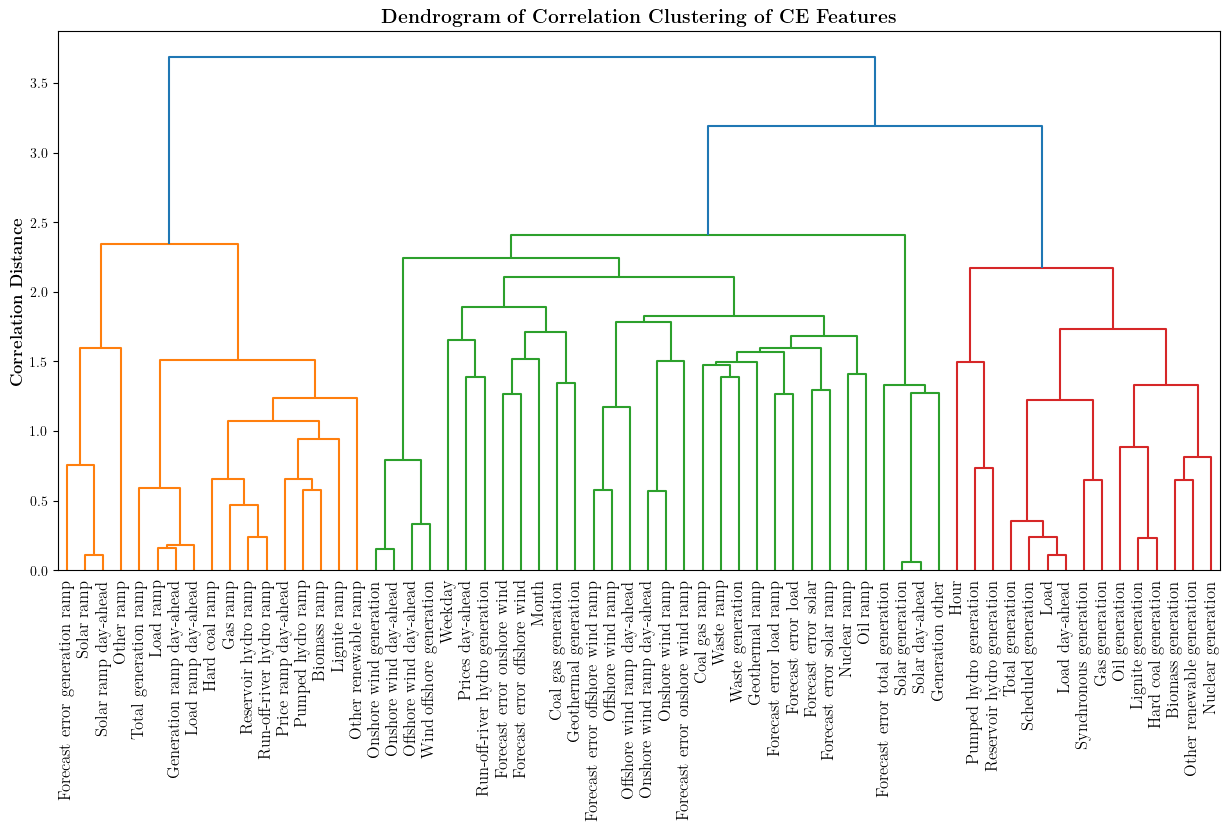

In [46]:
import pandas as pd
import numpy as np
import os
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform


def plot_correlation_clustering(area, data_version="2024-05-19", input_cols=None, save=False):
    version_folder = f"../data/2020-2024/{area}/version_{data_version}/yeo_johnson/"
    X_train = pd.read_hdf(version_folder + "X_train_full_scaled.h5")
    
    figure_path = (
        f"../../probabilistic-XAI-for-grid-frequency-stability/results/figures/correlation/{area}/"
    )
    
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    """
    correlation_matrix = X_train.corr(method='pearson')
    correlation_matrix = np.abs(np.corrcoef(correlation_matrix))
    dist_matrix = 1 - correlation_matrix
    #dist_matrix = (dist_matrix + dist_matrix.T) / 2
    """
    correlation_matrix = X_train.corr(method='pearson')

    correlation_matrix_abs = np.abs(correlation_matrix)
    dist_matrix_df = 1 - correlation_matrix_abs

    clustering = sch.linkage(dist_matrix_df, method="complete", optimal_ordering=True)
    
    if input_cols:
        labels = [input_cols.get(col, col) for col in X_train.columns]
    else:
        labels = X_train.columns
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    plt.figure(figsize=(15, 7))
    plt.title(r"\textbf{Dendrogram of Correlation Clustering of " + area + ' Features}', fontsize=14)
    dend = sch.dendrogram(clustering, labels=labels)
    
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', which='major', labelsize=12)
    plt.ylabel(r'\textbf{Correlation Distance}', fontsize=12)
    
    if save:
        plt.savefig(figure_path + "pearson_corr.pdf", bbox_inches='tight')
    plt.show()
    
    return clustering

clustering_result = plot_correlation_clustering(area="CE", input_cols=input_col_names, save=True)


In [ ]:
clustering_result_Nordic = plot_correlation_clustering(area="Nordic", input_cols=input_col_names, save=True)


In [12]:
import sys

sys.path.append("./")
sys.path.append("..")
from models.tabnet_proba import TabNetRegressorProba

fit_folder = (
    "../results/model_fit/{}/version_{}_"
    + config.model_combination
    + "/"
    + config.scaler_str
    + "/target_{}/"
)

reg = TabNetRegressorProba()
reg.load_model(
    filepath=fit_folder.format(area, config.res_version, "f_rocof")
    + "best_model_params.zip"
)

/home/kit/iai/wy8179/.conda/envs/patterns4/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


/scratch/ipykernel_187878/3634705902.py:19: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = sch.linkage(dist_matrix_df, method="complete", optimal_ordering=True)


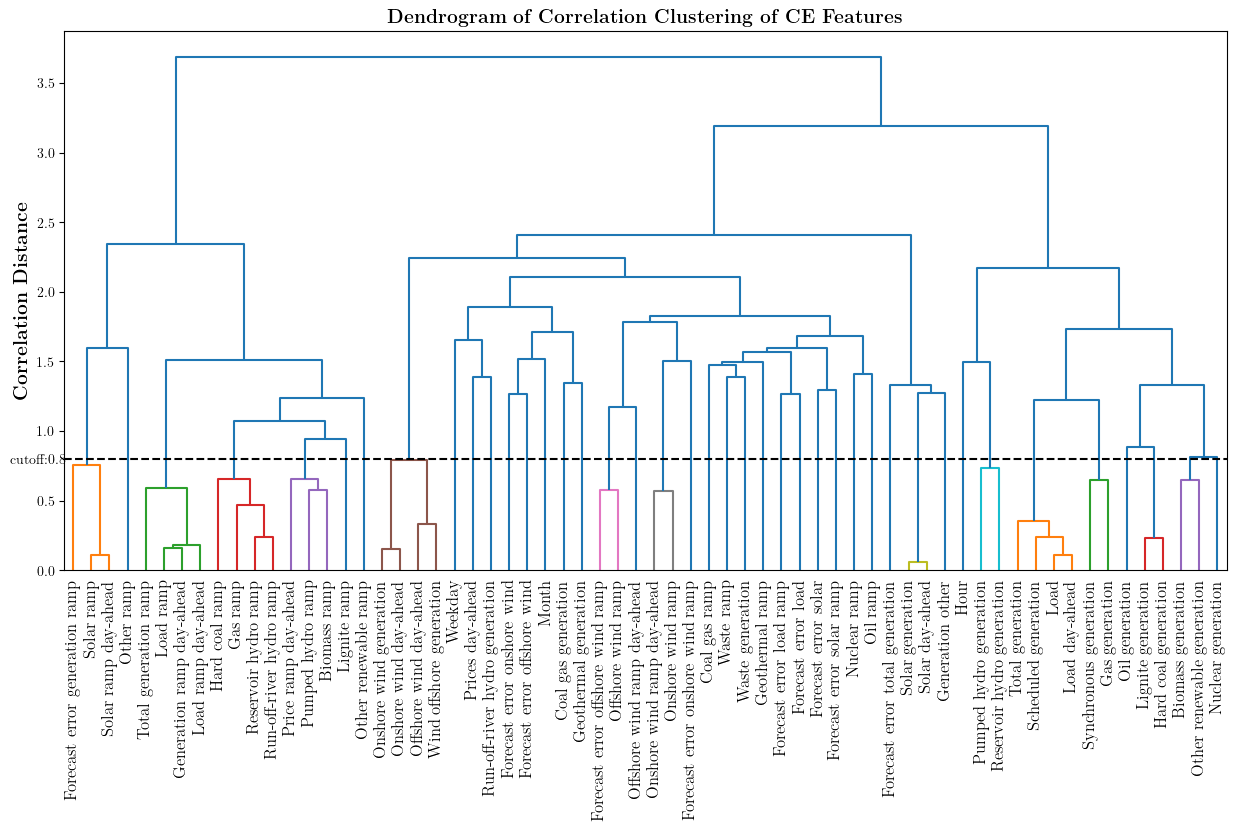

In [49]:
import scipy.cluster.hierarchy as sch

def plot_corr_clustering_cutoff(area,  cutoff : float,  data_version="2024-05-19", input_cols=None, save=False):
    version_folder = f"../data/2020-2024/{area}/version_{data_version}/yeo_johnson/"
    X_train = pd.read_hdf(version_folder + "X_train_full_scaled.h5")
    
    figure_path = (
        f"../../probabilistic-XAI-for-grid-frequency-stability/results/figures/correlation/{area}/"
    )
    
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    
    correlation_matrix = X_train.corr(method='pearson')

    correlation_matrix_abs = np.abs(correlation_matrix)
    dist_matrix_df = 1 - correlation_matrix_abs

    clustering = sch.linkage(dist_matrix_df, method="complete", optimal_ordering=True)
    
    if input_cols:
        labels = [input_cols.get(col, col) for col in X_train.columns]
    else:
        labels = X_train.columns
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    plt.figure(figsize=(15, 7))
    plt.title(r"\textbf{Dendrogram of Correlation Clustering of " + area + ' Features}', fontsize=14)
    #dend = sch.dendrogram(clustering, labels=labels)
    dend = sch.dendrogram(clustering, color_threshold=cutoff, labels=labels)
    plt.axhline(y=cutoff, c='k', lw=1.5, linestyle='--')
    plt.text(0.95, cutoff, f'cutoff:{cutoff}', va='center_baseline', ha='right', color='k', fontsize=10)

    
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', which='major', labelsize=12)
    plt.ylabel(r'\textbf{Correlation Distance}', fontsize=14)
    
    if save:
        plt.savefig(figure_path + f"pearson_corr_{area}_{cutoff}.pdf", bbox_inches='tight')
    plt.show()
    
    return clustering

clustering_result = plot_corr_clustering_cutoff(area="CE", cutoff=0.8, input_cols=input_col_names, save=True)


# Compare Explanations

In [31]:
fit_folder = (
    "../results/model_fit/{}/version_{}_"
    + config.model_combination
    + "/"
    + config.scaler_str
    + "/target_{}//explanations{}/"
)
shap_vals_permutation = np.load(
            fit_folder.format(area, config.res_version,  "f_rocof", "")
            + f"shap_values_mean.npy"
)
shap_vals_permutation_exp = shap.Explanation(shap_vals_permutation, feature_names=X_test.columns, data=X_test)

shap_vals_partition = np.load(
            fit_folder.format(area, config.res_version, "f_rocof", "_partition")
            + f"shap_values_mean.npy"
)
masker = shap.maskers.Partition(X_train, clustering=clustering)

shap_vals_partition_exp = shap.Explanation(shap_vals_partition, feature_names=X_test.columns, data=X_test)


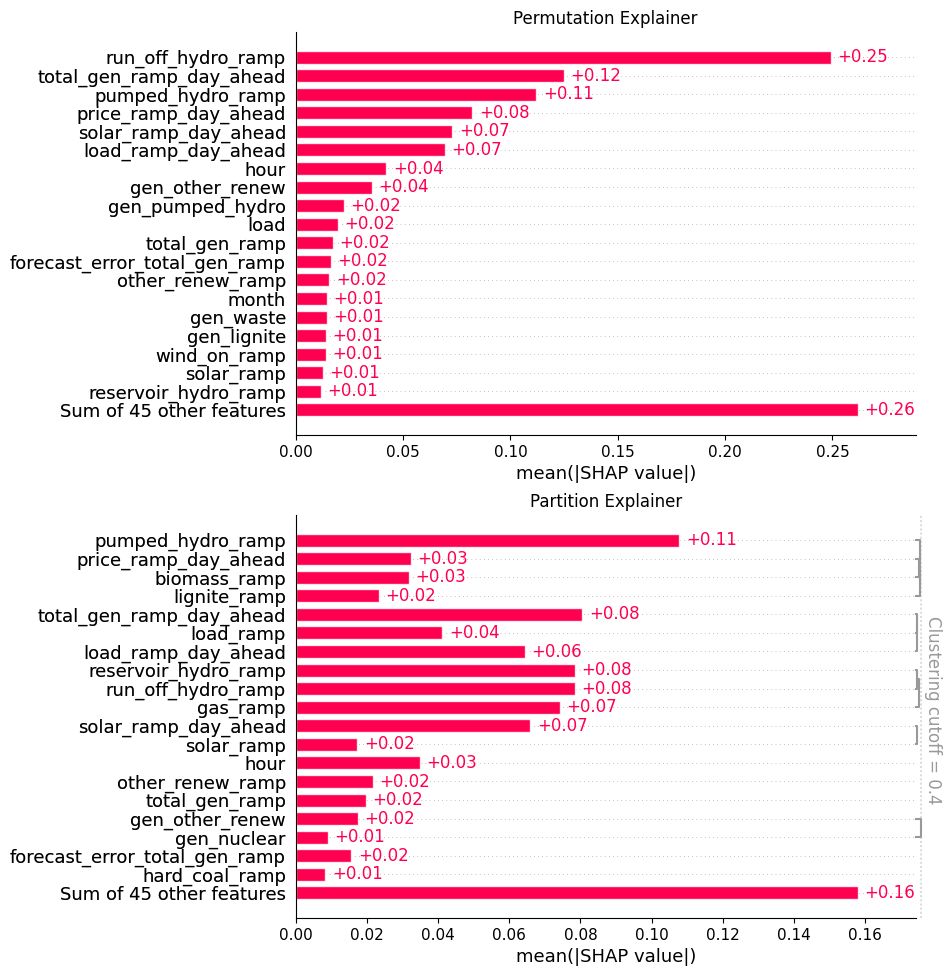

In [64]:
fig = plt.figure(figsize=(18,12))
ax0 = fig.add_subplot(211)
shap.plots.bar(shap_vals_permutation_exp, max_display=20, show=False)
ax0.set_title("Permutation Explainer")
ax1 = fig.add_subplot(212)
shap.plots.bar(shap_vals_partition_exp, max_display=20, show=False, clustering=clustering, clustering_cutoff=0.4)
ax1.set_title("Partition Explainer")
#plt.tight_layout()
plt.show()

In [ ]:
f = shap.force_plot(
    outputs.f_ext.mean(),
    shap_vals.values[np.argwhere(X_test.index == ind)[0, 0]],
    X_test.rename(columns=input_col_names).loc[ind].index,
    matplotlib=True,
    show=False,
    figsize=(20, 3),
)

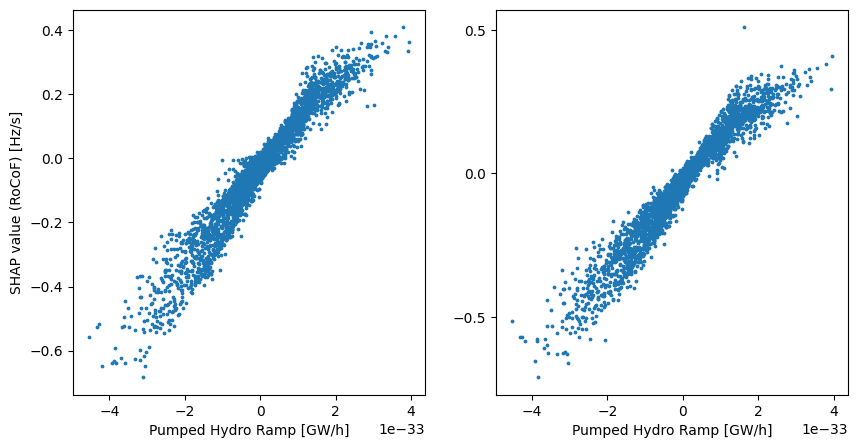

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ex_feature = "pumped_hydro_ramp"
X_test = X_test.mul(input_rescale_factors.reindex(X_test.columns))
shap_vals = shap_vals_partition.copy()
shap_vals = pd.DataFrame(index=X_test.index, columns=X_test.columns, data=shap_vals)
ax1.scatter(
    X_test.loc[:, ex_feature], shap_vals.loc[:, ex_feature], s=3
)
ax1.set_xlabel("Pumped Hydro Ramp [GW/h]")
ax1.set_ylabel("SHAP value (RoCoF) [Hz/s]")

plt.locator_params(axis="y", nbins=3)

shap_vals = shap_vals_permutation.copy()
shap_vals = pd.DataFrame(index=X_test.index, columns=X_test.columns, data=shap_vals)
ax2.scatter(
    X_test.loc[:, ex_feature], shap_vals.loc[:, ex_feature], s=3
)
ax2.set_xlabel("Pumped Hydro Ramp [GW/h]")
#plt.set_ylabel("SHAP value (RoCoF) [Hz/s]")
plt.locator_params(axis="y", nbins=3)

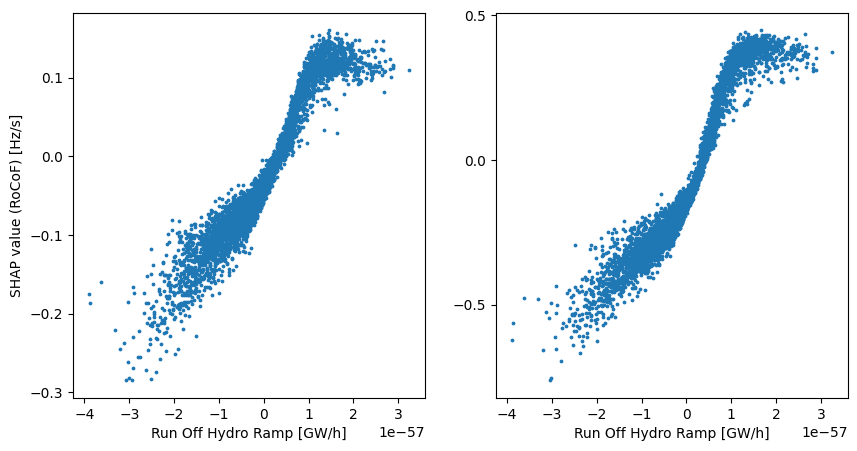

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ex_feature = "run_off_hydro_ramp"
X_test = X_test.mul(input_rescale_factors.reindex(X_test.columns))
shap_vals = shap_vals_partition.copy()
shap_vals = pd.DataFrame(index=X_test.index, columns=X_test.columns, data=shap_vals)
ax1.scatter(
    X_test.loc[:, ex_feature], shap_vals.loc[:, ex_feature], s=3
)
ax1.set_xlabel("Run Off Hydro Ramp [GW/h]")
ax1.set_ylabel("SHAP value (RoCoF) [Hz/s]")

plt.locator_params(axis="y", nbins=3)

shap_vals = shap_vals_permutation.copy()
shap_vals = pd.DataFrame(index=X_test.index, columns=X_test.columns, data=shap_vals)
ax2.scatter(
    X_test.loc[:, ex_feature], shap_vals.loc[:, ex_feature], s=3
)
ax2.set_xlabel("Run Off Hydro Ramp [GW/h]")
#plt.set_ylabel("SHAP value (RoCoF) [Hz/s]")
plt.locator_params(axis="y", nbins=3)

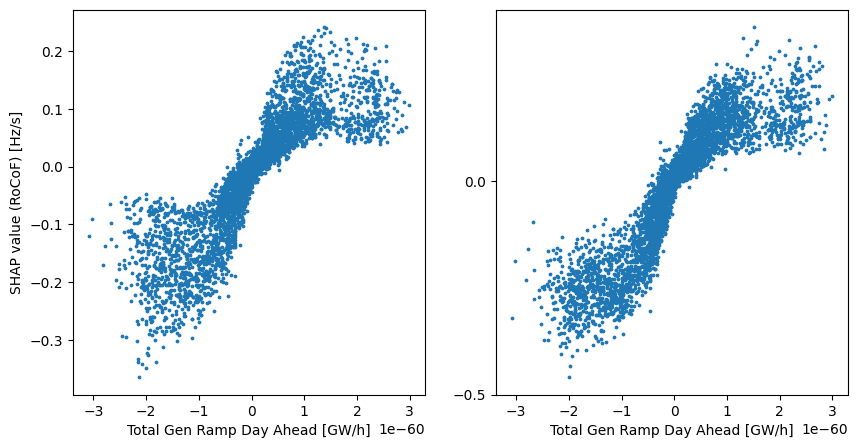

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ex_feature = "total_gen_ramp_day_ahead"
X_test = X_test.mul(input_rescale_factors.reindex(X_test.columns))
shap_vals = shap_vals_partition.copy()
shap_vals = pd.DataFrame(index=X_test.index, columns=X_test.columns, data=shap_vals)
ax1.scatter(
    X_test.loc[:, ex_feature], shap_vals.loc[:, ex_feature], s=3
)
ax1.set_xlabel("Total Gen Ramp Day Ahead [GW/h]")
ax1.set_ylabel("SHAP value (RoCoF) [Hz/s]")

plt.locator_params(axis="y", nbins=3)

shap_vals = shap_vals_permutation.copy()
shap_vals = pd.DataFrame(index=X_test.index, columns=X_test.columns, data=shap_vals)
ax2.scatter(
    X_test.loc[:, ex_feature], shap_vals.loc[:, ex_feature], s=3
)
ax2.set_xlabel("Total Gen Ramp Day Ahead [GW/h]")
#plt.set_ylabel("SHAP value (RoCoF) [Hz/s]")
plt.locator_params(axis="y", nbins=3)